In [1]:
import os
os.chdir("../")
print(os.getcwd())

/rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer


# Read Drag values while training

In [2]:
# def load(filename=None, keys=None):
# #     filename = path.Path(filename)
#     print(f'Loading checkpoint: {filename}')
#     file = open(filename, 'rb')
#     load_data = pickle.load(file)
# #     keys = tuple(data.keys() if keys is None else keys)
#     return load_data
# #     for key in keys:
# #       if key.startswith('_'):
# #         continue
# #       try:
# #         values[key].load(data[key])
# #       except Exception:
# #         print(f'Error loading {key} from checkpoint.')
# #         raise
# #     if self._log:
# #       age = time.time() - data['_timestamp']
# #       print(f'Loaded checkpoint from {age:.0f} seconds ago.')

# data = load(filename = "logdir/Cyl/First_Test/events.out.tfevents.1717606486.cx3-1-0.cx3.hpc.ic.ac.uk.2498444.0.v2")
# print(data.keys())

In [2]:
import yaml
import numpy as np
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# See configs.yaml for all options.
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# Load YAML file
with open('logdir/Cyl_Horizon_Length/Cyl_large_env10_rs1_actent3e-4_tr256_ihorizon150_CX3new/config.yaml', 'r') as file:
    loaded_config = yaml.safe_load(file)

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update(loaded_config)

2024-07-04 18:14:14.312291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 18:14:26.024323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reading config
Reading config


In [3]:
print(config.cyl.random_start)

True


In [4]:

logdir_name = config.logdir_basepath+'/'+\
       config.logdir_dirname+'/'+\
       config.logdir_expname
config = config.update({'logdir': logdir_name, 'jax.platform': 'cpu' })
logdir = embodied.Path(config.logdir)
# logdir.mkdirs()
config.save(config.logdir+"/config.yaml")
print('Logdir', logdir)
print("Number of Envs: ", config.envs.amount)

step = embodied.Counter()
logger = embodied.Logger(step, [
  embodied.logger.TerminalOutput(),
  embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
  embodied.logger.TensorBoardOutput(logdir),
  # embodied.logger.MLFlowOutput(logdir.name),
])

############################ Creating Env ##############################


# #make replay
# replay = embodied.replay.Uniform(
#             config.batch_length, config.replay_size, logdir / 'replay')
# eval_replay = make_replay(config, logdir / 'eval_replay', is_eval=True)
# eval_replay = embodied.replay.Uniform(
#               config.batch_length, config.replay_size, logdir / 'eval_replay')
#make env
# env = make_ks_env(config)
from make_flow_envs import make_flow_envs, make_cyl_env
from Cylinder_Env.simulation_base.env import resume_env
from embodied import wrappers
from embodied.envs import from_gym

# env = make_flow_envs(config, env_name="CYL", num_envs = config.envs.amount)
eval_env = resume_env(plot=False,
                      single_run=False,
                      horizon= 200,
                      dump_vtu= 500,
                      dump_debug = 10, 
                      random_start= True,
                      n_env=1,
                      simulation_duration=100,
                      sim_log_name = config.logdir_dirname+"/"+ \
                                         config.logdir_expname+"/test"
                      )
eval_env = from_gym.FromGym(eval_env, obs_key='vector')  # Or obs_key='vector'.
eval_env = dreamerv3.wrap_env(eval_env, config)
    
eval_env = embodied.BatchEnv([eval_env], parallel=False)

agent = dreamerv3.Agent(eval_env.obs_space, eval_env.act_space, step, config)
args  = embodied.Config(
  **config.run, logdir=config.logdir,
  batch_steps=config.batch_size * config.batch_length)

Logdir /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl_Horizon_Length/Cyl_large_env10_rs1_actent3e-4_tr256_ihorizon150_CX3new
Number of Envs:  30


--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           cx3-1-29
  Local device:         mlx5_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `whic

iUFL can be obtained from https://github.com/MiroK/ufl-interpreter
Initialising env number:  1
Number of probes: 64
Simulated 1630 iterations before starting the control
--- done buffers initialisation ---
Encoder CNN shapes: {}
Encoder MLP shapes: {'vector': (66,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'vector': (66,)}


2024-07-04 18:17:11.138288: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


JAX devices (1): [CpuDevice(id=0)]
Policy devices: TFRT_CPU_0
Train devices:  TFRT_CPU_0
Tracing train function.
Optimizer model_opt has 37,469,598 variables.
wm_outs:  {'cont_loss': Traced<ShapedArray(float32[16,32])>with<DynamicJaxprTrace(level=1/0)>, 'dyn_loss': Traced<ShapedArray(float32[16,32])>with<DynamicJaxprTrace(level=1/0)>, 'embed': Traced<ShapedArray(float16[16,32,758])>with<DynamicJaxprTrace(level=1/0)>, 'post': {'deter': Traced<ShapedArray(float16[16,32,2048])>with<DynamicJaxprTrace(level=1/0)>, 'logit': Traced<ShapedArray(float16[16,32,32,32])>with<DynamicJaxprTrace(level=1/0)>, 'stoch': Traced<ShapedArray(float16[16,32,32,32])>with<DynamicJaxprTrace(level=1/0)>}, 'prior': {'deter': Traced<ShapedArray(float16[16,32,2048])>with<DynamicJaxprTrace(level=1/0)>, 'logit': Traced<ShapedArray(float16[16,32,32,32])>with<DynamicJaxprTrace(level=1/0)>, 'stoch': Traced<ShapedArray(float16[16,32,32,32])>with<DynamicJaxprTrace(level=1/0)>}, 'rep_loss': Traced<ShapedArray(float32[16,32

Loading Checkpoint Model

In [5]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load(config.logdir+'/checkpoint.ckpt', keys=['agent'])

Loading checkpoint: /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl_Horizon_Length/Cyl_large_env10_rs1_actent3e-4_tr256_ihorizon150_CX3new/checkpoint.ckpt
Loaded checkpoint from 284 seconds ago.


Evaluating model with the environment

In [6]:
policy = lambda *args: agent.policy(*args, mode='eval')

## Model Eval

In [8]:
from embodied.core.basics import convert
import collections

#initializing actions
_acts = {k: convert(np.zeros((len(eval_env),) + v.shape, v.dtype))
        for k, v in eval_env.act_space.items()}
_acts['reset'] = np.ones(len(eval_env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(eval_env))]
_state = None

obs  = eval_env.step(_acts)

Number of probes: 64



KeyboardInterrupt



In [ ]:
imag_hori = 10

# agent.agent.train(obs, None)
agent.agent.wm.imagine(policy, )

## Policy Eval

In [7]:
from embodied.core.basics import convert
import collections

#initializing actions
_acts = {k: convert(np.zeros((len(eval_env),) + v.shape, v.dtype))
        for k, v in eval_env.act_space.items()}
_acts['reset'] = np.ones(len(eval_env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(eval_env))]
_state = None

In [ ]:
from tqdm import tqdm
obs_total = [] 
acts_total = []
qs_total = []
drag = []
lift = []
control_time = 100 #in env steps
actual_eval_env = eval_env.get_actual_env()

In [11]:

# acts['reset'] = [True]
# obs = env.reset()
for i in tqdm(range(30)):
    #take a step
    assert all(len(x) == len(eval_env) for x in _acts.values())
    acts = {k: v for k, v in _acts.items() if not k.startswith('log_')}
    obs  = eval_env.step(acts)

    #read observation
    obs = {k: convert(v) for k, v in obs.items()}
    assert all(len(x) == len(eval_env) for x in obs.values()), obs
    acts, _state = policy(obs, _state)
    print(acts)
    acts = {k: convert(v) for k, v in acts.items()}
    
    acts['reset'] = obs['is_last'].copy()
    _acts = acts
    acts_total.append(acts)
    qs_total.append(actual_eval_env[0].Qs)
#     print(f"{i}: obs: ", obs)
    obs_total.append(obs)
#     if config.run.log_specificenv_data !='':
#     actual_eval_env = eval_env.get_actual_env()
#     se_keys = config.run.log_specificenv_data.split(",")

#     for key in se_keys:
#       key = key.strip()
#       avg_key_val = np.mean(np.array([getattr(actual_eval_env[i], key) \
#                                       for i in range(len(actual_eval_env))]))
#       print(np.array([getattr(actual_eval_env[i], key) for i in range(len(actual_eval_env))]))
    drag.append(actual_eval_env[0].get_Cd())
#     lift.append(getattr(actual_eval_env[0], 'avg_lift'))

  3%|▎         | 1/30 [00:04<02:07,  4.39s/it]

{'action': array([[0.8487208, 0.9019726]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


  7%|▋         | 2/30 [00:08<02:02,  4.36s/it]

{'action': array([[-0.18724605,  0.9674712 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 10%|█         | 3/30 [00:13<01:57,  4.36s/it]

{'action': array([[0.74335843, 0.83119756]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 13%|█▎        | 4/30 [00:17<01:53,  4.35s/it]

{'action': array([[0.64312476, 0.9759563 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 17%|█▋        | 5/30 [00:21<01:48,  4.35s/it]

{'action': array([[0.8020293, 1.0400965]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 20%|██        | 6/30 [00:26<01:44,  4.37s/it]

{'action': array([[1.0340291, 0.9820684]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 23%|██▎       | 7/30 [00:30<01:40,  4.36s/it]

{'action': array([[0.6535576, 0.8453055]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 27%|██▋       | 8/30 [00:34<01:35,  4.35s/it]

{'action': array([[0.9864361, 1.0145563]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 30%|███       | 9/30 [00:39<01:31,  4.35s/it]

{'action': array([[0.414088  , 0.93700874]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 33%|███▎      | 10/30 [00:43<01:26,  4.35s/it]

{'action': array([[0.27225462, 0.85583955]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 37%|███▋      | 11/30 [00:47<01:22,  4.35s/it]

{'action': array([[0.55366784, 0.7952724 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 40%|████      | 12/30 [00:52<01:18,  4.35s/it]

{'action': array([[0.65979236, 0.97896135]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 43%|████▎     | 13/30 [00:56<01:13,  4.34s/it]

{'action': array([[1.1464467, 0.6987494]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 47%|████▋     | 14/30 [01:00<01:09,  4.36s/it]

{'action': array([[0.9502575, 0.6553091]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 50%|█████     | 15/30 [01:05<01:05,  4.35s/it]

{'action': array([[1.1199224 , 0.63715595]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 53%|█████▎    | 16/30 [01:09<01:00,  4.35s/it]

{'action': array([[0.97118896, 0.6213947 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 57%|█████▋    | 17/30 [01:15<01:02,  4.82s/it]

{'action': array([[0.87204075, 0.676177  ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 60%|██████    | 18/30 [01:21<01:02,  5.18s/it]

{'action': array([[1.0726966, 0.6878157]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 63%|██████▎   | 19/30 [01:27<00:59,  5.40s/it]

{'action': array([[1.2251418 , 0.52356106]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 67%|██████▋   | 20/30 [01:33<00:55,  5.53s/it]

{'action': array([[0.94482267, 0.53445226]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 70%|███████   | 21/30 [01:39<00:50,  5.62s/it]

{'action': array([[1.143768 , 0.5648566]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 73%|███████▎  | 22/30 [01:44<00:44,  5.55s/it]

{'action': array([[1.1175069 , 0.58766246]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 77%|███████▋  | 23/30 [01:49<00:36,  5.23s/it]

{'action': array([[0.98581535, 0.73019254]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 80%|████████  | 24/30 [01:53<00:30,  5.14s/it]

{'action': array([[1.2031051, 0.7774995]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 83%|████████▎ | 25/30 [01:58<00:24,  4.91s/it]

{'action': array([[0.91299045, 0.8119324 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 87%|████████▋ | 26/30 [02:02<00:18,  4.75s/it]

{'action': array([[1.1102288, 0.8502477]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 90%|█████████ | 27/30 [02:07<00:13,  4.63s/it]

{'action': array([[-0.03869708,  0.7704195 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 93%|█████████▎| 28/30 [02:11<00:09,  4.55s/it]

{'action': array([[0.98632586, 1.0002836 ]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


 97%|█████████▋| 29/30 [02:15<00:04,  4.50s/it]

{'action': array([[0.5922308, 1.0167898]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


100%|██████████| 30/30 [02:20<00:00,  4.67s/it]

{'action': array([[0.7503324 , 0.80856216]], dtype=float32), 'log_entropy': array([0.], dtype=float32)}


Text(0.5, 0, 'action steps')

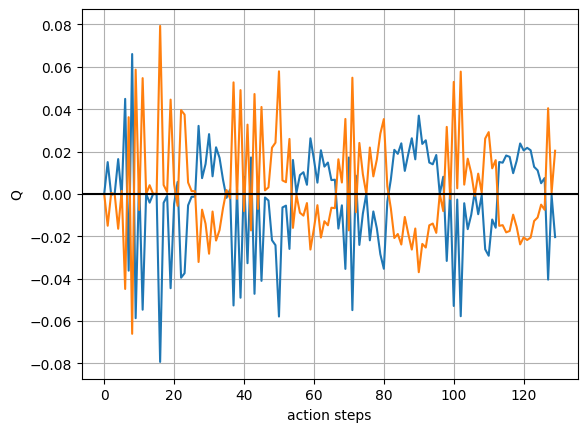

In [12]:
import matplotlib.pyplot as plt
plt.plot(qs_total)
plt.axhline(y=0, color='black', linestyle='-')
plt.grid('on')
plt.ylabel("Q")
plt.xlabel("action steps")

Text(0, 0.5, 'Cd')

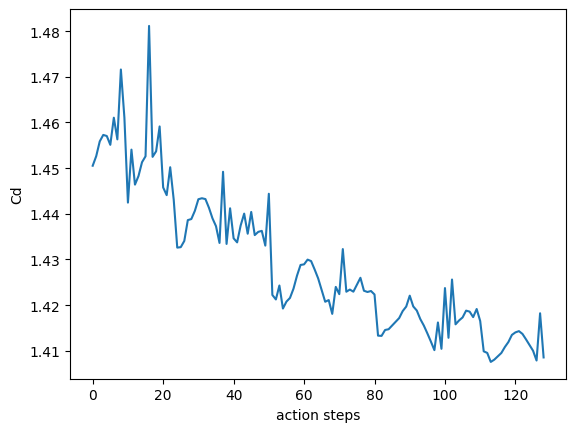

In [13]:
# log_specificenv_data = "episode_drags, avg_drag"
# actual_env = eval_env.get_actual_env()
# se_keys = log_specificenv_data.split(",")
drags = actual_eval_env[0].episode_drags[::actual_eval_env[0].number_steps_execution]
plt.plot(np.arange(drags.shape[0]), -2*drags)
plt.xlabel("action steps")
plt.ylabel("Cd")

Text(0, 0.5, 'Cl')

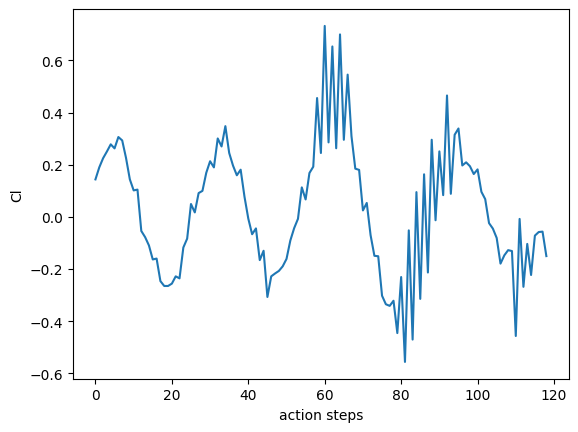

In [13]:
# log_specificenv_data = "episode_drags, avg_drag"
# actual_env = eval_env.get_actual_env()
# se_keys = log_specificenv_data.split(",")
lifts = actual_eval_env[0].episode_lifts[::actual_eval_env[0].number_steps_execution]
plt.plot(np.arange(drags.shape[0]), 2*lifts)
plt.xlabel("action steps")
plt.ylabel("Cl")

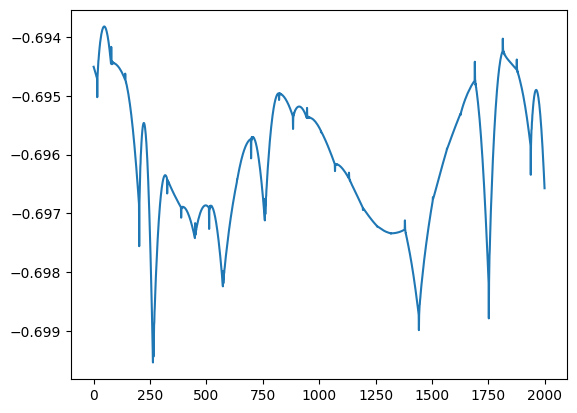

In [25]:
plt.plot(actual_eval_env[0].history_parameters["drag"].get())#[::-actual_eval_env[0].number_steps_execution])

In [15]:
#Collecting Reward and observations
import matplotlib.pyplot as plt

obs_data = obs_total[0]['vector']
obs_reward = obs_total[0]['reward']
acts_data = acts_total[0]['action']
for i in range(1,control_time):
    obs_data   = np.concatenate((obs_data  , obs_total[i]['vector']), axis = 0)
    obs_reward = np.concatenate((obs_reward, obs_total[i]['reward']), axis = 0)
    acts_data  = np.concatenate((acts_data , acts_total[i]['action']) , axis = 0)

# total_obs_data = np.concatenate((u_hist, obs_data), axis = 0)

print("obs_data shape: ", obs_data.shape)
# print("total_obs_data shape: ", total_obs_data.shape)
print("obs_reward shape: ", obs_reward.shape)
print("acts_data shape: ", acts_data.shape)

obs_data shape:  (200, 66)
obs_reward shape:  (200,)
acts_data shape:  (200, 2)


In [48]:
actual_env = eval_env.get_actual_env()
print(actual_env.)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 actual_env = eval_env.get_actual_env()                                                       │
│ ❱ 2 print(actual_env.episode_drags)                                                              │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'episode_drags'

In [20]:
plt.figure()
action_step_dt = 0.25
drag = -2*np.array(actual_eval_env.episode_drags)
plt.plot(np.arange(drag.shape[0])*action_step_dt,drag)
plt.grid()
plt.xlabel("t")
plt.ylabel("Cd")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 plt.figure()                                                                                 │
│   2 action_step_dt = 0.25                                                                        │
│ ❱ 3 drag = -2*np.array(actual_eval_env.episode_drags)                                            │
│   4 plt.plot(np.arange(drag.shape[0])*action_step_dt,drag)                                       │
│   5 plt.grid()                                                                                   │
│   6 plt.xlabel("t")                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'episode_drags'

<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'Reward')

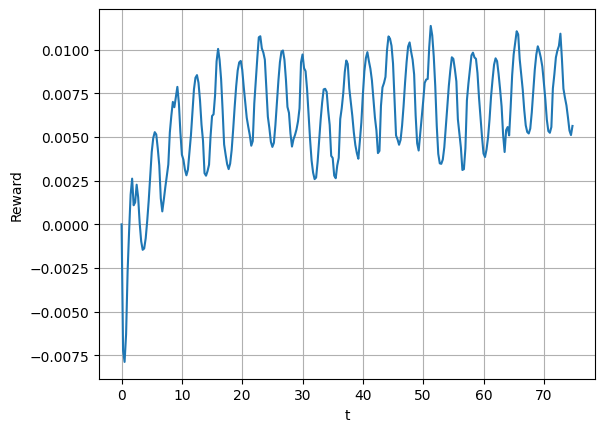

In [71]:
plt.figure()
action_step_dt = 0.25
plt.plot(np.arange(obs_reward.shape[0])*action_step_dt,obs_reward)
plt.grid()
plt.xlabel("t")
plt.ylabel("Reward")

# plt.figure()
# plt.hist(acts_data.flatten())

# plt.figure()
# from scipy.stats import norm
# mu, std = norm.fit(acts_data.flatten())

# # Generate points on the x-axis
# xmin = acts_data.flatten().min() - 3 * std
# xmax = acts_data.flatten().max() + 3 * std
# x = np.linspace(xmin, xmax, 100)

# # Generate the PDF values
# p = norm.pdf(x, mu, std)

# # Plot the PDF curve
# plt.plot(x, p, 'k', linewidth=2)

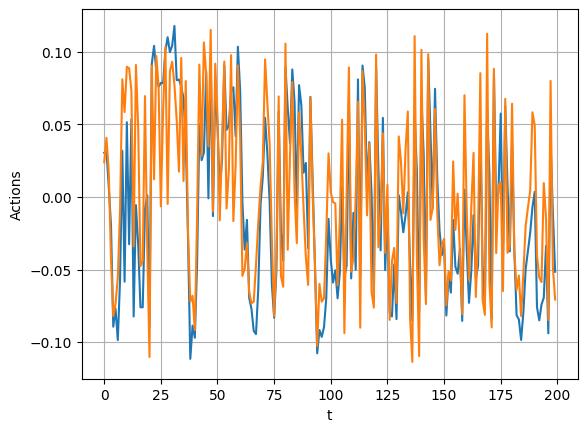

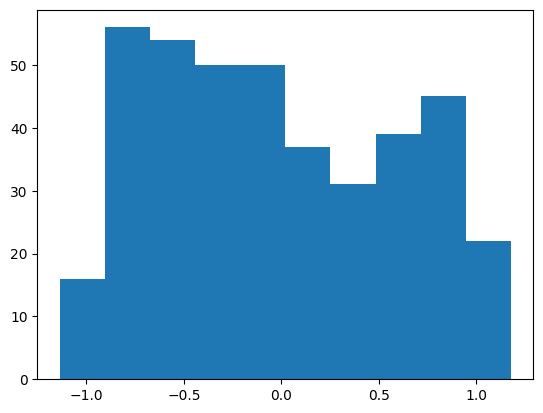

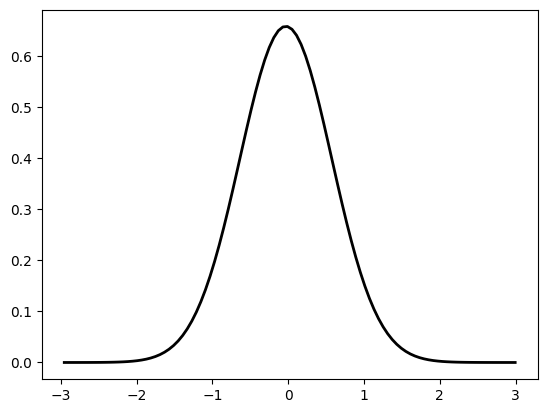

In [39]:
import matplotlib.pyplot as plt
plt.figure()
action_step_dt = 1
plt.plot(np.arange(acts_data.shape[0])*action_step_dt,acts_data*0.1)
plt.grid()
plt.xlabel("t")
plt.ylabel("Actions")

plt.figure()
plt.hist(acts_data.flatten())

plt.figure()
from scipy.stats import norm
mu, std = norm.fit(acts_data.flatten())

# Generate points on the x-axis
xmin = acts_data.flatten().min() - 3 * std
xmax = acts_data.flatten().max() + 3 * std
x = np.linspace(xmin, xmax, 100)

# Generate the PDF values
p = norm.pdf(x, mu, std)

# Plot the PDF curve
plt.plot(x, p, 'k', linewidth=2)